In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/egyptian-hieroglyphic-text/Glyph2025/u35/090030_u35.png
/kaggle/input/egyptian-hieroglyphic-text/Glyph2025/n8/n8_2.png
/kaggle/input/egyptian-hieroglyphic-text/Glyph2025/n8/n8_13.png
/kaggle/input/egyptian-hieroglyphic-text/Glyph2025/n8/n8_6.png
/kaggle/input/egyptian-hieroglyphic-text/Glyph2025/n8/n8_5.jpg
/kaggle/input/egyptian-hieroglyphic-text/Glyph2025/n8/n8_11.png
/kaggle/input/egyptian-hieroglyphic-text/Glyph2025/n8/n8_7.jpg
/kaggle/input/egyptian-hieroglyphic-text/Glyph2025/n8/n8_14.png
/kaggle/input/egyptian-hieroglyphic-text/Glyph2025/n8/n8_3.jpg
/kaggle/input/egyptian-hieroglyphic-text/Glyph2025/n8/n8_16.png
/kaggle/input/egyptian-hieroglyphic-text/Glyph2025/n8/n8_9.png
/kaggle/input/egyptian-hieroglyphic-text/Glyph2025/n8/n8_10.png
/kaggle/input/egyptian-hieroglyphic-text/Glyph2025/n8/n8_1.jpg
/kaggle/input/egyptian-hieroglyphic-text/Glyph2025/n8/n8_12.png
/kaggle/input/egyptian-hieroglyphic-text/Glyph2025/n8/n8_15.png
/kaggle/input/egyptian-hieroglyphic-text/

# Data Processing (Do not change)

In [2]:
import os
import cv2
import random
import shutil
import numpy as np
from tqdm import tqdm
from pathlib import Path

# ===================== CONFIG =====================
DATA_DIR = "/kaggle/input/egyptian-hieroglyphic-text/Glyph2025"           # your input folder (folders = classes)
OUTPUT_DIR = "/kaggle/working/Processed"   # output folder
IMG_SIZE = 224
TRAIN_RATIO, VAL_RATIO = 0.8, 0.2
MIN_REQUIRED = 15               # min samples per class for meta-train eligibility
SEED = 42
os.makedirs(OUTPUT_DIR, exist_ok=True)
random.seed(SEED)
np.random.seed(SEED)
# ==================================================

def preprocess_image(img_path):
    """Preprocess one image: grayscale, contrast normalize, background flatten, normalize."""
    img = cv2.imread(str(img_path))
    if img is None:
        raise ValueError(f"Cannot read image: {img_path}")

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Contrast normalization (CLAHE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray = clahe.apply(gray)

    # Illumination correction (background flattening)
    blur = cv2.GaussianBlur(gray, (55, 55), 0)
    corrected = cv2.addWeighted(gray, 1.5, blur, -0.5, 0)

    # Normalize to [0, 255]
    normalized = cv2.normalize(corrected, None, 0, 255, cv2.NORM_MINMAX)

    # Resize
    resized = cv2.resize(normalized, (IMG_SIZE, IMG_SIZE))

    return resized

def collect_class_images(data_dir):
    """Collect all (class_name, image_paths) pairs."""
    all_images = []
    classes = sorted(os.listdir(data_dir))
    for c in classes:
        
        if c.lower().startswith("archive"):
            continue
             
        class_dir = Path(data_dir) / c
        if not class_dir.is_dir():
            continue
        imgs = list(class_dir.glob("*"))
        if len(imgs) == 0:
            continue
        all_images.append((c, imgs))
    return all_images

def split_by_availability(class_images, min_required=20):
    """Separate classes into eligible (>=min_required) and rare (<min_required)."""
    eligible, rare = [], []
    for c, imgs in class_images:
        if len(imgs) >= min_required:
            eligible.append((c, imgs))
        else:
            rare.append((c, imgs))
    return eligible, rare

def split_classes(eligible_classes, train_ratio=0.8):
    """Split eligible classes into train/val."""
    classes = [c for c, imgs in eligible_classes]
    random.shuffle(classes)
    n_train = int(len(classes) * train_ratio)
    train_classes = classes[:n_train]
    val_classes = classes[n_train:]
    return train_classes, val_classes

def save_split(class_images, split_name, selected_classes):
    """Process and save images for a specific split."""
    split_dir = Path(OUTPUT_DIR) / split_name
    split_dir.mkdir(parents=True, exist_ok=True)

    for c, imgs in tqdm(class_images, desc=f"Processing {split_name}"):
        if c not in selected_classes:
            continue
        class_out = split_dir / c
        class_out.mkdir(parents=True, exist_ok=True)
        for img_path in imgs:
            try:
                processed = preprocess_image(img_path)
                out_path = class_out / (img_path.stem + ".png")
                cv2.imwrite(str(out_path), processed)
            except Exception as e:
                print(f"⚠️ Error processing {img_path}: {e}")

def main():
    # Step 1: Collect all classes and images
    class_images = collect_class_images(DATA_DIR)
    print(f"Found {len(class_images)} classes in total.")

    # Step 2: Split into eligible and rare based on sample count
    eligible_classes, rare_classes = split_by_availability(class_images, MIN_REQUIRED)
    print(f"Eligible classes (≥{MIN_REQUIRED} samples): {len(eligible_classes)}")
    print(f"Rare classes (<{MIN_REQUIRED} samples): {len(rare_classes)}")

    # Step 3: Split eligible into train/val by class
    train_classes, val_classes = split_classes(eligible_classes, TRAIN_RATIO)
    print(f"Train classes: {len(train_classes)} | Val classes: {len(val_classes)}")

    # Step 4: Save processed images
    save_split(eligible_classes, "meta_train", train_classes)
    save_split(eligible_classes, "meta_val", val_classes)
    save_split(rare_classes, "meta_test", [c for c, _ in rare_classes])

    print("\n✅ Done!")
    print(f"Data saved in: {OUTPUT_DIR}")
    print("Folders: meta_train / meta_val / meta_test")

if __name__ == "__main__":
    main()


Found 353 classes in total.
Eligible classes (≥15 samples): 128
Rare classes (<15 samples): 225
Train classes: 102 | Val classes: 26


Processing meta_train:  12%|█▎        | 16/128 [00:18<02:07,  1.14s/it]

⚠️ Error processing /kaggle/input/egyptian-hieroglyphic-text/Glyph2025/d40/desktop.ini: Cannot read image: /kaggle/input/egyptian-hieroglyphic-text/Glyph2025/d40/desktop.ini


Processing meta_test: 100%|██████████| 225/225 [00:10<00:00, 20.60it/s]


✅ Done!
Data saved in: /kaggle/working/Processed
Folders: meta_train / meta_val / meta_test


# Instructions


1. **Copy the notebook in Kaggle** (right-click → "Copy & Edit").
2. **Edit only**:
   - `CONFIG` cell (experiment metadata; change `MODEL_NAME`, `EXPERIMENTER`, `SEED` and other details in the foundational paper).
   - **Model Definition** cell (replace ProtoNet with your architecture; ensure it exposes `embed` and `forward(support_x, support_y, query_x)` interface OR adapt training functions accordingly).
   
3. **Run** the notebook from top to bottom. Check `/kaggle/working/results/<RUN_ID>/` for outputs.
4. **Submit** results by creating a single CSV row for your run in `results/summary.csv` (or push to your shared storage).
5. **Important**: Do not alter the `meta_train/meta_val/meta_test` split or sample code to ensure comparability.


# Imports & environment

In [3]:
# Install PyTorch Geometric if not available
try:
    import torch_geometric
except ImportError:
    !pip install torch-geometric torch-scatter torch-sparse -q
    import torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 43.6 MB/s eta 0:00:00


In [4]:
# Imports and environment setup
import os
import random
import json
import time
from pathlib import Path
from collections import defaultdict
from datetime import datetime
import math

import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch_geometric.nn import GATConv, GraphSAGE
from torch_geometric.data import Data, Batch
import torch_geometric.nn as gnn
from torchvision import models
# Reproducibility helper
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


# CONFIG (edit this cell for each experiment)

In [18]:

# ==================== CONFIG ====================

CONFIG = {
    "MODEL_NAME": "HPGN_Small",
    "EXPERIMENTER": "Aya",
    "DATA_ROOT": "/kaggle/working/Processed",
    "SAVE_ROOT": "/kaggle/working/results",
    "N_WAY": 5,
    "K_SHOT_LIST": [1, 5],
    "Q_QUERY": 5,                    
    "EPISODES_PER_EPOCH": 1000,      
    "META_BATCH_SIZE": 1,            
    "VAL_EPISODES": 500,             
    "TEST_EPISODES": 2000,           
    "LR": 1e-4,                      
    "WEIGHT_DECAY": 1e-4,            
    "MAX_EPOCHS": 50,                
    "PATIENCE": 8,                   
    "SEED": 42,
    "PRINT_EVERY": 100,              
    "SAVE_EVERY_EPOCHS": 1,
    "NOTES": "Simplified HPGN for small hieroglyph dataset with strong regularization"
}
# Derived
CONFIG["RUN_ID"] = f"{CONFIG['MODEL_NAME']}_{CONFIG['EXPERIMENTER']}_{CONFIG['SEED']}_{datetime.now().strftime('%Y%m%d-%H%M%S')}"
print("Config RUN_ID:", CONFIG["RUN_ID"])
set_seed(CONFIG["SEED"])
os.makedirs(CONFIG["SAVE_ROOT"], exist_ok=True)


Config RUN_ID: HPGN_Small_Aya_42_20251226-115432


# Data Augmentation

In [6]:
# ==================== DATA AUGMENTATION ====================

from torchvision import transforms

def get_train_transform():
    """Aggressive augmentation for training to combat overfitting"""
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomRotation(15),                    # Hieroglyphs can be at angles
        transforms.RandomAffine(
            degrees=0, 
            translate=(0.1, 0.1),                        # Small translations
            scale=(0.9, 1.1)                             # Small scaling
        ),
        transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
        transforms.ColorJitter(brightness=0.3, contrast=0.3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]),
        transforms.RandomErasing(p=0.3, scale=(0.02, 0.1))  # Simulate occlusions
    ])

def get_val_transform():
    """No augmentation for validation/test"""
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

train_transform = get_train_transform()
val_transform = get_val_transform()

def load_image(path, is_training=True):
    """Load image with appropriate transform"""
    img = Image.open(path).convert("L")
    transform = train_transform if is_training else val_transform
    return transform(img)

# Utilities: file helpers, save functions

In [7]:
def make_save_dir(config):
    path = Path(config["SAVE_ROOT"]) / config["RUN_ID"]
    path.mkdir(parents=True, exist_ok=True)
    return path

SAVE_DIR = make_save_dir(CONFIG)
def save_json(obj, p):
    with open(p, "w") as f:
        json.dump(obj, f, indent=2)

def save_csv(df, p):
    df.to_csv(p, index=False)

# Save config snapshot
save_json(CONFIG, SAVE_DIR / "config.json")
print("Saving outputs to:", SAVE_DIR)


Saving outputs to: /kaggle/working/results/HPGN_Small_Aya_42_20251226-090836


# Dataset utilities: class-wise loader & listing

In [8]:
class ClassFolderDataset:
    """Helper to read class->list(image_paths) mapping for a folder root."""
    def __init__(self, root):
        self.root = Path(root)
        assert self.root.exists(), f"Path not found: {root}"
        self.classes = sorted([d.name for d in self.root.iterdir() if d.is_dir()])
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}
        self.class_images = {}
        for c in self.classes:
            imgs = sorted(list((self.root / c).glob("*.*")))
            if len(imgs) == 0:
                continue
            self.class_images[c] = imgs

    def num_classes(self):
        return len(self.class_images)

    def class_counts(self):
        return {c: len(v) for c, v in self.class_images.items()}

# Sanity load check
train_root = Path(CONFIG["DATA_ROOT"]) / "meta_train"
val_root = Path(CONFIG["DATA_ROOT"]) / "meta_val"
test_root = Path(CONFIG["DATA_ROOT"]) / "meta_test"

train_set = ClassFolderDataset(train_root)
val_set = ClassFolderDataset(val_root)
test_set = ClassFolderDataset(test_root)

print("Train classes:", train_set.num_classes())
print("Val classes:", val_set.num_classes())
print("Test classes:", test_set.num_classes())


Train classes: 102
Val classes: 26
Test classes: 225


# Image transform helper

In [9]:
# ==================== IMAGE TRANSFORMS WITH AUGMENTATION ====================

from torchvision import transforms
from PIL import Image

def get_train_transform():
    """Aggressive augmentation for training to combat overfitting"""
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomRotation(15),
        transforms.RandomAffine(
            degrees=0, 
            translate=(0.1, 0.1),
            scale=(0.9, 1.1)
        ),
        transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
        transforms.ColorJitter(brightness=0.3, contrast=0.3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]),
        transforms.RandomErasing(p=0.3, scale=(0.02, 0.1))
    ])

def get_val_transform():
    """No augmentation for validation/test"""
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

# Create transform instances
train_transform = get_train_transform()
val_transform = get_val_transform()

def load_image(path, is_training=True):
    """Load image with appropriate transform based on training mode"""
    img = Image.open(path).convert("L")
    transform = train_transform if is_training else val_transform
    return transform(img)

# Episodic Sampler (N-way K-shot episode creation)

In [10]:
from torchvision.models import resnet18, ResNet18_Weights


In [11]:
# ==================== EPISODIC SAMPLER WITH AUGMENTATION ====================

def sample_episode(class_images_dict, n_way, k_shot, q_query, is_training=True):
    """
    Sample episode with training/validation mode
    """
    eligible = [c for c, imgs in class_images_dict.items() if len(imgs) >= (k_shot + q_query)]
    if len(eligible) < n_way:
        raise ValueError(f"Not enough eligible classes for N-way={n_way}, eligible={len(eligible)}")
    selected = random.sample(eligible, n_way)
    support_imgs, support_lbls = [], []
    query_imgs, query_lbls = [], []

    for label_idx, c in enumerate(selected):
        imgs = random.sample(class_images_dict[c], k_shot + q_query)
        support_paths = imgs[:k_shot]
        query_paths = imgs[k_shot:]
        
        for p in support_paths:
            support_imgs.append(load_image(p, is_training=is_training))
            support_lbls.append(label_idx)
        for p in query_paths:
            query_imgs.append(load_image(p, is_training=is_training))
            query_lbls.append(label_idx)
    
    support_x = torch.stack(support_imgs).to(device)
    support_y = torch.tensor(support_lbls, dtype=torch.long, device=device)
    query_x = torch.stack(query_imgs).to(device)
    query_y = torch.tensor(query_lbls, dtype=torch.long, device=device)
    return support_x, support_y, query_x, query_y

# ProtoNet model (example) (Change to your model)

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torchvision.models import resnet18


# ==================== RESNET ENCODER ====================
class ResNetEncoder(nn.Module):
    def __init__(self, global_dim=128, local_channels=64):
        super().__init__()
        # Load ResNet18, NOT pretrained
        self.resnet = resnet18(weights=None)
        # Modify first conv layer to accept grayscale (1 channel)
        self.resnet.conv1 = nn.Conv2d(
            1, 64, kernel_size=7, stride=2, padding=3, bias=False
        )
        # Cut off the classifier head
        self.features = nn.Sequential(
            self.resnet.conv1,
            self.resnet.bn1,
            self.resnet.relu,
            self.resnet.maxpool,
            self.resnet.layer1,
            self.resnet.layer2,
            self.resnet.layer3,
            self.resnet.layer4,   # → final feature map (local features)
        )
        # Local feature channels (ResNet18 → 512)
        local_feat_dim = 512
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc_global = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(local_feat_dim, global_dim)
        )
    
    def forward(self, x):
        local_feat = self.features(x)                         # B × 512 × H × W
        pooled = self.global_pool(local_feat)                 # B × 512 × 1 × 1
        global_emb = self.fc_global(pooled.squeeze(-1).squeeze(-1))
        return global_emb, local_feat


# ==================== PATCH PROTOTYPE MODULE ====================
class SimplifiedPatchPrototype(nn.Module):
    """Fewer prototypes for small dataset"""
    def __init__(self, local_channels=512, patch_dim=64, num_prototypes=2):
        super().__init__()
        self.num_prototypes = num_prototypes
        self.patch_dim = patch_dim

        self.patch_proj = nn.Sequential(
            nn.Linear(local_channels, patch_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(patch_dim, patch_dim)
        )

        self.proto_queries = nn.Parameter(torch.randn(num_prototypes, patch_dim))
        self.attn = nn.MultiheadAttention(patch_dim, num_heads=2, batch_first=True, dropout=0.1)

    def forward(self, local_feat):
        B, C, H, W = local_feat.shape
        patches = local_feat.view(B, C, -1).permute(0, 2, 1)  # B × (H*W) × C
        patch_emb = self.patch_proj(patches)                   # B × (H*W) × patch_dim
        queries = self.proto_queries.unsqueeze(0).expand(B, -1, -1)  # B × num_proto × patch_dim
        prototypes, _ = self.attn(queries, patch_emb, patch_emb)
        return prototypes


# ==================== GLOBAL-LOCAL FUSION MODULE ====================
class GlobalLocalFusion(nn.Module):
    """Three fusion strategies for combining global and local information"""
    def __init__(self, proto_dim=64, global_dim=128, fusion_type='gated'):
        super().__init__()
        self.fusion_type = fusion_type
        
        if fusion_type == 'concatenate':
            # Simple concatenation (no learnable params)
            self.output_dim = proto_dim + global_dim
            
        elif fusion_type == 'gated':
            # Gated fusion with learnable gate
            self.gate = nn.Sequential(
                nn.Linear(proto_dim + global_dim, proto_dim),
                nn.Sigmoid()
            )
            self.global_transform = nn.Linear(global_dim, proto_dim)
            self.output_dim = proto_dim
            
        elif fusion_type == 'mlp':
            # MLP fusion
            self.fusion_mlp = nn.Sequential(
                nn.Linear(proto_dim + global_dim, proto_dim),
                nn.ReLU(),
                nn.Dropout(0.1),
                nn.Linear(proto_dim, proto_dim)
            )
            self.output_dim = proto_dim
    
    def forward(self, prototypes, global_emb):
        """
        Args:
            prototypes: B × K × proto_dim
            global_emb: B × global_dim
        Returns:
            fused: B × K × output_dim
        """
        B, K, D = prototypes.shape
        
        # Expand global to match prototype dimensions
        global_expanded = global_emb.unsqueeze(1).expand(B, K, -1)  # B × K × global_dim
        
        if self.fusion_type == 'concatenate':
            # Simple concatenation
            fused = torch.cat([prototypes, global_expanded], dim=-1)
            
        elif self.fusion_type == 'gated':
            # Gated fusion
            global_transformed = self.global_transform(global_expanded)
            concat = torch.cat([prototypes, global_expanded], dim=-1)
            gate = self.gate(concat)
            fused = gate * prototypes + (1 - gate) * global_transformed
            
        elif self.fusion_type == 'mlp':
            # MLP fusion
            concat = torch.cat([prototypes, global_expanded], dim=-1)
            fused = self.fusion_mlp(concat)
        
        return fused


# ==================== PROTOTYPE GNN ====================
class SimplifiedPrototypeGNN(nn.Module):
    """Single GNN layer to reduce overfitting"""
    def __init__(self, proto_dim=64, hidden_dim=64):
        super().__init__()
        
        self.gat = GATConv(proto_dim, hidden_dim, heads=2, concat=False, dropout=0.1)
        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(0.1)

    def build_graph_fast(self, prototypes, labels, k_neighbors=2):
        N = prototypes.shape[0]
        k = min(k_neighbors + 1, N)

        dist = torch.cdist(prototypes, prototypes)
        _, indices = torch.topk(dist, k=k, largest=False, dim=1)

        src = torch.arange(N, device=prototypes.device).unsqueeze(1).expand(-1, k)
        dst = indices

        src_flat = src.reshape(-1)
        dst_flat = dst.reshape(-1)
        mask = src_flat != dst_flat

        edge_index = torch.stack([src_flat[mask], dst_flat[mask]], dim=0)
        return edge_index

    def forward(self, prototypes, labels):
        edge_index = self.build_graph_fast(prototypes, labels, k_neighbors=2)
        x = prototypes
        x_new = self.gat(x, edge_index)
        x_new = self.layer_norm(x_new)
        x_new = F.relu(x_new)
        x_new = self.dropout(x_new)
        x = x + x_new  # Residual
        return x


# ==================== MAIN HPGN MODEL ====================
class HPGN_Small(nn.Module):
    """
    Simplified HPGN for small datasets with global-local fusion
    
    Args:
        global_dim: Dimension of global embedding (default: 128)
        local_channels: Not used anymore (ResNet outputs 512)
        patch_dim: Dimension of patch prototypes (default: 64)
        num_prototypes: Number of prototypes per image (default: 2)
        use_global: Whether to use global embedding (default: True)
        fusion_type: How to fuse global and local ('concatenate', 'gated', 'mlp', or None)
        use_ensemble: Use separate global classifier and ensemble predictions
    """
    def __init__(self, global_dim=128, local_channels=64, patch_dim=64, 
                 num_prototypes=2, use_global=True, fusion_type='gated',
                 use_ensemble=False, ensemble_alpha=0.3):
        super().__init__()
        self.num_prototypes = num_prototypes
        self.patch_dim = patch_dim
        self.use_global = use_global
        self.fusion_type = fusion_type
        self.use_ensemble = use_ensemble
        
        # Encoder
        self.encoder = ResNetEncoder(
            global_dim=global_dim,
            local_channels=512  # ResNet18 output
        )

        # Patch prototype module
        self.patch_module = SimplifiedPatchPrototype(
            local_channels=512,
            patch_dim=patch_dim,
            num_prototypes=num_prototypes
        )

        # Global-local fusion (if enabled)
        if use_global and fusion_type is not None:
            self.fusion_module = GlobalLocalFusion(
                proto_dim=patch_dim,
                global_dim=global_dim,
                fusion_type=fusion_type
            )
            gnn_input_dim = self.fusion_module.output_dim
        else:
            self.fusion_module = None
            gnn_input_dim = patch_dim

        # GNN
        self.gnn = SimplifiedPrototypeGNN(
            proto_dim=gnn_input_dim,
            hidden_dim=gnn_input_dim
        )
        
        # Ensemble mode: learnable weight
        if use_ensemble:
            self.ensemble_alpha = nn.Parameter(torch.tensor(ensemble_alpha))

    def extract_features(self, x):
        global_emb, local_feat = self.encoder(x)
        patch_prototypes = self.patch_module(local_feat)
        
        # Apply fusion if enabled
        if self.use_global and self.fusion_module is not None:
            patch_prototypes = self.fusion_module(patch_prototypes, global_emb)
        
        return global_emb, patch_prototypes

    def forward(self, support_x, support_y, query_x):
        n_way = torch.unique(support_y).numel()

        # Extract features
        support_global, support_prototypes = self.extract_features(support_x)
        query_global, query_prototypes = self.extract_features(query_x)
        
        # === LOCAL PROTOTYPE PATH ===
        B_support, K_proto, D = support_prototypes.shape

        # Flatten prototypes for GNN
        support_proto_flat = support_prototypes.reshape(-1, D)
        support_labels_expanded = support_y.unsqueeze(1).expand(-1, K_proto).contiguous().reshape(-1)

        # Refine with GNN
        refined_support_proto = self.gnn(support_proto_flat, support_labels_expanded)

        # Create class prototypes (average over each class)
        class_prototypes = []
        for c in range(n_way):
            class_mask = support_labels_expanded == c
            class_proto = refined_support_proto[class_mask].mean(dim=0)
            class_prototypes.append(class_proto)
        class_prototypes = torch.stack(class_prototypes)

        # Query embeddings (average over prototypes)
        query_emb = query_prototypes.mean(dim=1)

        # Compute distances and logits
        dists_local = torch.cdist(query_emb, class_prototypes)
        logits_local = -dists_local
        
        # === GLOBAL PATH (if ensemble mode) ===
        if self.use_ensemble:
            # Create global class prototypes
            global_class_prototypes = []
            for c in range(n_way):
                mask = support_y == c
                global_class_prototypes.append(support_global[mask].mean(dim=0))
            global_class_prototypes = torch.stack(global_class_prototypes)
            
            # Compute global distances
            dists_global = torch.cdist(query_global, global_class_prototypes)
            logits_global = -dists_global
            
            # Ensemble (learnable weight)
            alpha = torch.sigmoid(self.ensemble_alpha)
            logits = alpha * logits_global + (1 - alpha) * logits_local
        else:
            logits = logits_local

        return logits


# Instantiate your model, optimizer, scheduler

In [13]:
# ==================== MODEL INSTANTIATION ====================

model = HPGN_Small(
    global_dim=128,
    local_channels=64,
    patch_dim=64,
    num_prototypes=2
).to(device)

# Remove the separate dropout regularization - it's now built into the model

optimizer = torch.optim.AdamW(  # AdamW is better for regularization
    model.parameters(),
    lr=CONFIG["LR"],
    weight_decay=CONFIG["WEIGHT_DECAY"]
)

# Cosine annealing with warm restarts
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=5,      # Restart every 5 epochs
    T_mult=2,   # Double the period after each restart
    eta_min=1e-6
)

print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

Total parameters: 11,831,912


# Training utilities: loss, accuracy, evaluate_episode

In [14]:
# ==================== Training utilities with regularization ====================

def episode_loss_and_acc(model, support_x, support_y, query_x, query_y):
    """Standard training function (for backward compatibility)"""
    return episode_loss_and_acc_with_smoothing(
        model, support_x, support_y, query_x, query_y, 
        smoothing=0.1  # Add label smoothing
    )

# ==================== UPDATED EVALUATION FUNCTION ====================

def evaluate_on_episodes(model, class_images_dict, n_way, k_shot, q_query, 
                         episodes=200, is_training=False):
    """
    Evaluate model on episodes with proper train/val mode
    
    Args:
        model: The model to evaluate
        class_images_dict: Dictionary of class names to image paths
        n_way: Number of classes per episode
        k_shot: Number of support examples per class
        q_query: Number of query examples per class
        episodes: Number of episodes to evaluate
        is_training: Whether to use training augmentation (default False for eval)
    
    Returns:
        mean_loss: Average loss across episodes
        mean_acc: Average accuracy across episodes
        accs: Array of per-episode accuracies
    """
    model.eval()
    losses, accs = [], []
    
    with torch.no_grad():
        for _ in range(episodes):
            support_x, support_y, query_x, query_y = sample_episode(
                class_images_dict, n_way, k_shot, q_query,
                is_training=is_training  # Use this parameter
            )
            logits = model(support_x, support_y, query_x)
            loss = F.cross_entropy(logits, query_y).item()
            pred = logits.argmax(dim=1)
            acc = (pred == query_y).float().mean().item()
            losses.append(loss)
            accs.append(acc)
    
    return np.mean(losses), np.mean(accs), np.array(accs)

# Training loop

In [15]:
# ==================== TRAINING LOOP WITH MIXUP ====================

def mixup_data(x, y, alpha=0.2):
    """Mixup augmentation for better generalization"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(pred, y_a, y_b, lam):
    return lam * F.cross_entropy(pred, y_a) + (1 - lam) * F.cross_entropy(pred, y_b)

n_way = CONFIG["N_WAY"]
meta_batch = CONFIG["META_BATCH_SIZE"]
episodes_per_epoch = CONFIG["EPISODES_PER_EPOCH"]
val_episodes = CONFIG["VAL_EPISODES"]

best_val = -1.0
epochs_no_improve = 0
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "lr": []}

for epoch in range(1, CONFIG["MAX_EPOCHS"] + 1):
    model.train()
    epoch_losses = []
    epoch_accs = []
    start = time.time()

    for ep in range(episodes_per_epoch):
        optimizer.zero_grad()
        batch_loss = 0.0
        batch_acc = 0.0

        for _ in range(meta_batch):
            # Sample with training augmentation
            support_x, support_y, query_x, query_y = sample_episode(
                train_set.class_images,
                n_way,
                CONFIG["K_SHOT_LIST"][-1],
                CONFIG["Q_QUERY"],
                is_training=True  # Use augmentation
            )

            # Apply mixup with 30% probability on query set
            if random.random() < 0.3:
                query_x, query_y_a, query_y_b, lam = mixup_data(query_x, query_y, alpha=0.2)
                logits = model(support_x, support_y, query_x)
                loss = mixup_criterion(logits, query_y_a, query_y_b, lam)
                pred = logits.argmax(dim=1)
                acc = (lam * (pred == query_y_a).float() + (1-lam) * (pred == query_y_b).float()).mean().item()
            else:
                logits = model(support_x, support_y, query_x)
                # Label smoothing
                n_classes = logits.size(1)
                smoothing = 0.1
                with torch.no_grad():
                    true_dist = torch.zeros_like(logits)
                    true_dist.fill_(smoothing / (n_classes - 1))
                    true_dist.scatter_(1, query_y.unsqueeze(1), 1.0 - smoothing)
                loss = (-true_dist * F.log_softmax(logits, dim=1)).sum(dim=1).mean()
                pred = logits.argmax(dim=1)
                acc = (pred == query_y).float().mean().item()

            loss.backward()
            batch_loss += loss.item()
            batch_acc += acc

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        optimizer.step()

        epoch_losses.append(batch_loss / meta_batch)
        epoch_accs.append(batch_acc / meta_batch)

        if (ep + 1) % CONFIG["PRINT_EVERY"] == 0:
            avg_loss = batch_loss / meta_batch
            avg_acc = batch_acc / meta_batch
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch} Ep {ep+1}/{episodes_per_epoch} - "
                  f"loss {avg_loss:.4f} - acc {avg_acc:.4f} - lr {current_lr:.6f}")

    # Validation (no augmentation)
    val_loss, val_acc, _ = evaluate_on_episodes(
        model, val_set.class_images, n_way,
        CONFIG["K_SHOT_LIST"][-1], CONFIG["Q_QUERY"],
        episodes=val_episodes,
        is_training=False
    )

    scheduler.step()  # Step the scheduler

    train_loss = np.mean(epoch_losses)
    train_acc = np.mean(epoch_accs)
    current_lr = optimizer.param_groups[0]['lr']

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    history["lr"].append(current_lr)

    elapsed = time.time() - start
    gap = train_acc - val_acc

    print(f"\n{'='*60}")
    print(f"Epoch {epoch} Summary ({elapsed/60:.2f} min):")
    print(f"  Train: loss={train_loss:.4f}, acc={train_acc:.4f}")
    print(f"  Val:   loss={val_loss:.4f}, acc={val_acc:.4f}")
    print(f"  Gap: {gap:.4f}, LR: {current_lr:.6f}")
    print(f"{'='*60}\n")

    # Early stopping with best model saving
    if val_acc > best_val:
        best_val = val_acc
        epochs_no_improve = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
        }, SAVE_DIR / "best_model.pth")
        save_json({"best_val": float(best_val), "epoch": epoch}, SAVE_DIR / "best_meta.json")
        print(f"  ✅ New best validation: {best_val:.4f}")
    else:
        epochs_no_improve += 1
        print(f"  ⏳ No improvement for {epochs_no_improve} epoch(s)")
        if epochs_no_improve >= CONFIG["PATIENCE"]:
            print("  🛑 Early stopping triggered.")
            break

# Save training history
pd.DataFrame(history).to_csv(SAVE_DIR / "history.csv", index=False)
print(f"\n✅ Training finished. Best val acc: {best_val:.4f}")

Epoch 1 Ep 100/1000 - loss 1.1580 - acc 0.5200 - lr 0.000100
Epoch 1 Ep 200/1000 - loss 0.8637 - acc 0.6800 - lr 0.000100
Epoch 1 Ep 300/1000 - loss 1.1745 - acc 0.6000 - lr 0.000100
Epoch 1 Ep 400/1000 - loss 1.0429 - acc 0.6000 - lr 0.000100
Epoch 1 Ep 500/1000 - loss 0.8096 - acc 0.4776 - lr 0.000100
Epoch 1 Ep 600/1000 - loss 0.9869 - acc 0.8000 - lr 0.000100
Epoch 1 Ep 700/1000 - loss 0.7282 - acc 0.8400 - lr 0.000100
Epoch 1 Ep 800/1000 - loss 0.6063 - acc 0.8384 - lr 0.000100
Epoch 1 Ep 900/1000 - loss 1.1283 - acc 0.4799 - lr 0.000100
Epoch 1 Ep 1000/1000 - loss 1.1364 - acc 0.6400 - lr 0.000100

Epoch 1 Summary (4.28 min):
  Train: loss=1.0344, acc=0.6413
  Val:   loss=0.5787, acc=0.7841
  Gap: -0.1428, LR: 0.000091

  ✅ New best validation: 0.7841
Epoch 2 Ep 100/1000 - loss 0.8719 - acc 0.8400 - lr 0.000091
Epoch 2 Ep 200/1000 - loss 0.8819 - acc 0.8800 - lr 0.000091
Epoch 2 Ep 300/1000 - loss 1.0119 - acc 0.6800 - lr 0.000091
Epoch 2 Ep 400/1000 - loss 0.8147 - acc 0.8400 - 

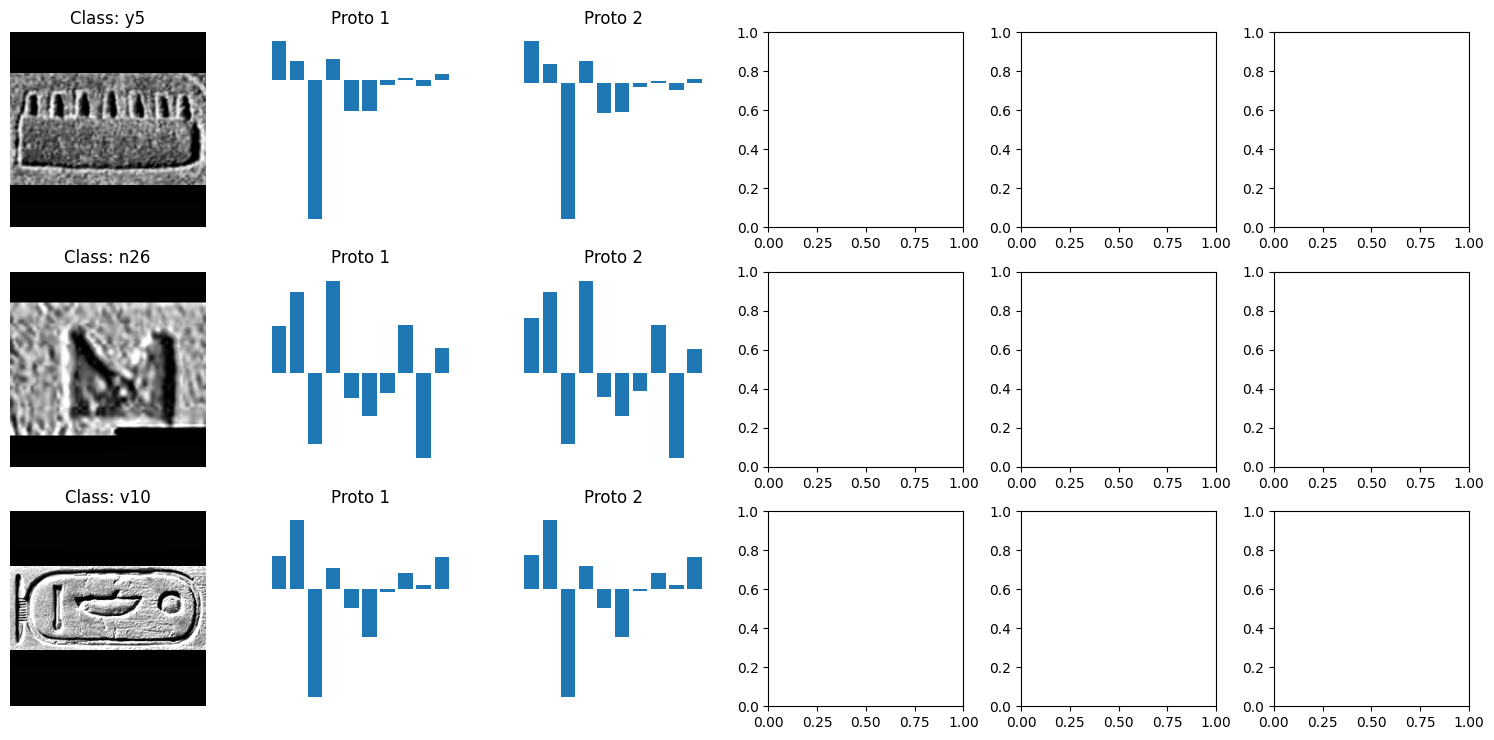

In [16]:
# Visualize sample prototypes and attention
def visualize_prototypes(model, class_images_dict, n_samples=3):
    model.eval()
    fig, axes = plt.subplots(n_samples, 6, figsize=(15, n_samples*2.5))
    
    classes = random.sample(list(class_images_dict.keys()), min(n_samples, len(class_images_dict)))
    
    with torch.no_grad():
        for i, c in enumerate(classes):
            img_path = random.choice(class_images_dict[c])
            img_tensor = load_image(img_path).unsqueeze(0).to(device)
            
            _, prototypes = model.extract_features(img_tensor)
            
            # Show original image
            axes[i, 0].imshow(Image.open(img_path), cmap='gray')
            axes[i, 0].set_title(f"Class: {c[:10]}")
            axes[i, 0].axis('off')
            
            # Show prototype visualizations (simplified)
            for j in range(min(5, prototypes.shape[1])):
                axes[i, j+1].bar(range(min(10, prototypes.shape[2])), 
                                prototypes[0, j, :10].cpu().numpy())
                axes[i, j+1].set_title(f"Proto {j+1}")
                axes[i, j+1].axis('off')
    
    plt.tight_layout()
    plt.savefig(SAVE_DIR / "prototype_visualization.png")
    plt.show()

# Run visualization
visualize_prototypes(model, train_set.class_images, n_samples=3)

# Evaluation on meta_test with bootstrap CI

In [19]:
# ==================== LOAD BEST MODEL FOR TESTING ====================

checkpoint = torch.load(
    "/kaggle/working/results/HPGN_Small_Aya_42_20251226-090836/best_model.pth",
    map_location=device,
    weights_only=False
)

# Extract model state dict from checkpoint
if 'model_state_dict' in checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✅ Loaded best model from epoch {checkpoint['epoch']} with val_acc={checkpoint['val_acc']:.4f}")
else:
    # If it's already just the state dict
    model.load_state_dict(checkpoint)
    print("✅ Loaded model state dict")

model.to(device)
model.eval()

def bootstrap_ci(acc_array, n_bootstrap=1000, ci=0.95):
    """Bootstrap confidence intervals"""
    n = len(acc_array)
    means = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(acc_array, size=n, replace=True)
        means.append(sample.mean())
    lower = np.percentile(means, (1-ci)/2*100)
    upper = np.percentile(means, (1+(ci))/2*100)
    return np.mean(means), lower, upper


results = []
for k_shot in CONFIG["K_SHOT_LIST"]:
    print(f"Evaluating {CONFIG['N_WAY']}-way {k_shot}-shot on meta_test, {CONFIG['TEST_EPISODES']} episodes...")
    # generate episodes and collect per-episode accuracies
    _, _, accs = evaluate_on_episodes(model, test_set.class_images, CONFIG["N_WAY"], k_shot, CONFIG["Q_QUERY"], episodes=CONFIG["TEST_EPISODES"])
    mean_acc, lower, upper = bootstrap_ci(accs, n_bootstrap=1000, ci=0.95)
    results.append({
        "n_way": CONFIG["N_WAY"],
        "k_shot": k_shot,
        "mean_acc": float(mean_acc),
        "ci_lower": float(lower),
        "ci_upper": float(upper),
        "num_episodes": len(accs)
    })
    print(f"Result: {mean_acc*100:.2f}% (95% CI: {lower*100:.2f} – {upper*100:.2f})")

results_df = pd.DataFrame(results)
save_csv(results_df, SAVE_DIR / "test_results.csv")
print("Saved test results.")


✅ Loaded best model from epoch 30 with val_acc=0.9407
Evaluating 5-way 1-shot on meta_test, 2000 episodes...
Result: 86.48% (95% CI: 86.02 – 86.95)
Evaluating 5-way 5-shot on meta_test, 2000 episodes...
Result: 95.67% (95% CI: 95.43 – 95.90)
Saved test results.


# Plots: learning curves & final results table

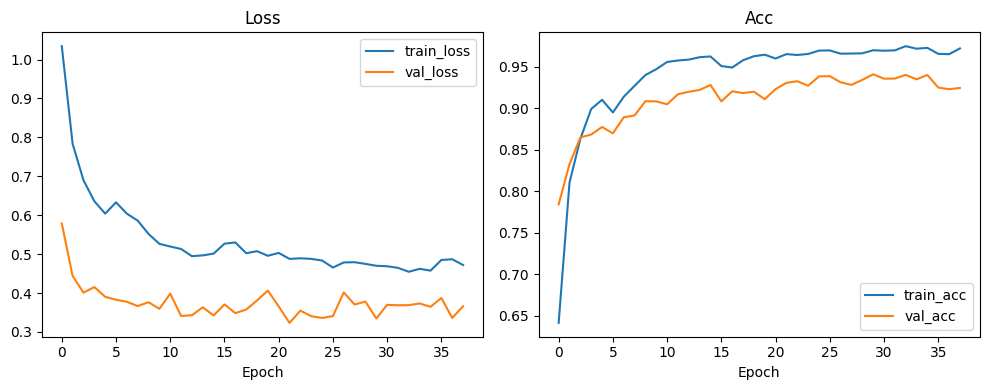

,n_way,k_shot,mean_acc,ci_lower,ci_upper,num_episodes
0,5,1,0.864816,0.86016,0.869481,2000
1,5,5,0.956748,0.95434,0.959021,2000


In [20]:
# Learning curves
history_df = pd.read_csv(SAVE_DIR / "history.csv")
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_df['train_loss'], label='train_loss')
plt.plot(history_df['val_loss'], label='val_loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.subplot(1,2,2)
plt.plot(history_df['train_acc'], label='train_acc')
plt.plot(history_df['val_acc'], label='val_acc')
plt.title("Acc")
plt.xlabel("Epoch")
plt.legend()
plt.tight_layout()
plt.savefig(SAVE_DIR / "learning_curves.png")
plt.show()

# Results table
display(results_df)


# Save full run manifest & final notes

In [21]:
manifest = {
    "run_id": CONFIG["RUN_ID"],
    "model_name": CONFIG["MODEL_NAME"],
    "experimenter": CONFIG["EXPERIMENTER"],
    "config": CONFIG,
    "results": results
}
save_json(manifest, SAVE_DIR / "manifest.json")
print("Run manifest saved at:", SAVE_DIR / "manifest.json")

# Quick summary print
for r in results:
    print(f"{r['n_way']}-way {r['k_shot']}-shot: {r['mean_acc']*100:.2f}% (95% CI: {r['ci_lower']*100:.2f} - {r['ci_upper']*100:.2f})")


Run manifest saved at: /kaggle/working/results/HPGN_Small_Aya_42_20251226-090836/manifest.json
5-way 1-shot: 86.48% (95% CI: 86.02 - 86.95)
5-way 5-shot: 95.67% (95% CI: 95.43 - 95.90)


In [22]:
!zip -r HPGN_Small_Aya_42_20251129-124616.zip "/kaggle/working/results/HPGN_Small_Aya_42_20251226-090836"

  adding: kaggle/working/results/HPGN_Small_Aya_42_20251226-090836/ (stored 0%)
  adding: kaggle/working/results/HPGN_Small_Aya_42_20251226-090836/manifest.json (deflated 52%)
  adding: kaggle/working/results/HPGN_Small_Aya_42_20251226-090836/learning_curves.png (deflated 6%)
  adding: kaggle/working/results/HPGN_Small_Aya_42_20251226-090836/best_meta.json (deflated 2%)
  adding: kaggle/working/results/HPGN_Small_Aya_42_20251226-090836/config.json (deflated 40%)
  adding: kaggle/working/results/HPGN_Small_Aya_42_20251226-090836/best_model.pth (deflated 9%)
  adding: kaggle/working/results/HPGN_Small_Aya_42_20251226-090836/test_results.csv (deflated 29%)
  adding: kaggle/working/results/HPGN_Small_Aya_42_20251226-090836/history.csv (deflated 55%)
  adding: kaggle/working/results/HPGN_Small_Aya_42_20251226-090836/prototype_visualization.png (deflated 12%)


# Protonet

In [ ]:
# ==================== PROTONET CONFIG ====================

PROTONET_CONFIG = {
    "MODEL_NAME": "ProtoNet_Baseline",
    "EXPERIMENTER": "Aya",
    "DATA_ROOT": "/kaggle/working/Processed",
    "SAVE_ROOT": "/kaggle/working/results",
    "N_WAY": 5,
    "K_SHOT_LIST": [1, 5],
    "Q_QUERY": 5,                    # Reduced from 10
    "EPISODES_PER_EPOCH": 1000,       # Reduced from 1000
    "META_BATCH_SIZE": 1,            # Reduced from 2
    "VAL_EPISODES": 500,             # Reduced from 500
    "TEST_EPISODES": 20000,           # Reduced from 2000
    "LR": 1e-4,                      # Lower learning rate
    "WEIGHT_DECAY": 1e-4,            # Increased regularization
    "MAX_EPOCHS": 50,                # Increased epochs
    "PATIENCE": 8,                   # Increased patience
    "SEED": 42,
    "PRINT_EVERY": 100,              # More frequent printing
    "SAVE_EVERY_EPOCHS": 1,
    "NOTES": "ProtoNet baseline with ResNet18 encoder for comparison"
}

PROTONET_CONFIG["RUN_ID"] = f"{PROTONET_CONFIG['MODEL_NAME']}_{PROTONET_CONFIG['EXPERIMENTER']}_{PROTONET_CONFIG['SEED']}_{datetime.now().strftime('%Y%m%d-%H%M%S')}"
print("ProtoNet Config RUN_ID:", PROTONET_CONFIG["RUN_ID"])

# Create save directory
PROTONET_SAVE_DIR = Path(PROTONET_CONFIG["SAVE_ROOT"]) / PROTONET_CONFIG["RUN_ID"]
PROTONET_SAVE_DIR.mkdir(parents=True, exist_ok=True)
save_json(PROTONET_CONFIG, PROTONET_SAVE_DIR / "config.json")

In [ ]:
# ==================== PROTONET BASELINE IMPLEMENTATION ====================

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class ProtoNetEncoder(nn.Module):
    """Standard CNN encoder for ProtoNet"""
    def __init__(self, embedding_dim=512):
        super().__init__()
        # Use ResNet18 as backbone
        resnet = models.resnet18(pretrained=False)
        # Modify first conv for grayscale input
        resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Remove final FC layer
        self.encoder = nn.Sequential(*list(resnet.children())[:-1])
        
        # Add projection head
        self.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(512, embedding_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(embedding_dim, embedding_dim)
        )
        
    def forward(self, x):
        """
        Args:
            x: [B, 1, H, W]
        Returns:
            embeddings: [B, embedding_dim]
        """
        features = self.encoder(x)  # [B, 512, 1, 1]
        features = features.squeeze(-1).squeeze(-1)  # [B, 512]
        embeddings = self.fc(features)  # [B, embedding_dim]
        return embeddings


class ProtoNet(nn.Module):
    """Prototypical Network for Few-Shot Learning"""
    def __init__(self, embedding_dim=512):
        super().__init__()
        self.encoder = ProtoNetEncoder(embedding_dim)
        self.embedding_dim = embedding_dim
    
    def forward(self, support_x, support_y, query_x):
        """
        Args:
            support_x: [N*K, C, H, W] - support images
            support_y: [N*K] - support labels (0 to N-1)
            query_x: [Q, C, H, W] - query images
        Returns:
            logits: [Q, N] - classification logits
        """
        # Encode support and query images
        support_embeddings = self.encoder(support_x)  # [N*K, D]
        query_embeddings = self.encoder(query_x)      # [Q, D]
        
        # Compute class prototypes (mean of support embeddings per class)
        n_way = torch.unique(support_y).numel()
        prototypes = []
        
        for c in range(n_way):
            class_mask = (support_y == c)
            class_embeddings = support_embeddings[class_mask]
            prototype = class_embeddings.mean(dim=0)
            prototypes.append(prototype)
        
        prototypes = torch.stack(prototypes)  # [N, D]
        
        # Compute euclidean distances from queries to prototypes
        dists = torch.cdist(query_embeddings, prototypes)  # [Q, N]
        
        # Convert to logits (negative distances)
        logits = -dists
        
        return logits

print("✅ ProtoNet baseline defined")

In [ ]:
# ==================== INITIALIZE PROTONET ====================

set_seed(PROTONET_CONFIG["SEED"])

protonet_model = ProtoNet(embedding_dim=512).to(device)

protonet_optimizer = torch.optim.AdamW(
    protonet_model.parameters(),
    lr=PROTONET_CONFIG["LR"],
    weight_decay=PROTONET_CONFIG["WEIGHT_DECAY"]
)

protonet_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    protonet_optimizer,
    T_0=5,
    T_mult=2,
    eta_min=1e-6
)

print(f"ProtoNet parameters: {sum(p.numel() for p in protonet_model.parameters()):,}")

In [ ]:
# ==================== PROTONET TRAINING LOOP ====================

n_way = PROTONET_CONFIG["N_WAY"]
meta_batch = PROTONET_CONFIG["META_BATCH_SIZE"]
episodes_per_epoch = PROTONET_CONFIG["EPISODES_PER_EPOCH"]
val_episodes = PROTONET_CONFIG["VAL_EPISODES"]

best_val = -1.0
epochs_no_improve = 0
protonet_history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "lr": []}

print(f"\n{'='*60}")
print(f"Training ProtoNet Baseline")
print(f"{'='*60}\n")

for epoch in range(1, PROTONET_CONFIG["MAX_EPOCHS"] + 1):
    protonet_model.train()
    epoch_losses = []
    epoch_accs = []
    start = time.time()

    for ep in range(episodes_per_epoch):
        protonet_optimizer.zero_grad()
        batch_loss = 0.0
        batch_acc = 0.0

        for _ in range(meta_batch):
            # Sample episode with training augmentation
            support_x, support_y, query_x, query_y = sample_episode(
                train_set.class_images,
                n_way,
                PROTONET_CONFIG["K_SHOT_LIST"][-1],
                PROTONET_CONFIG["Q_QUERY"],
                is_training=True
            )

            # Forward pass
            logits = protonet_model(support_x, support_y, query_x)
            
            # Loss with label smoothing
            n_classes = logits.size(1)
            smoothing = 0.1
            with torch.no_grad():
                true_dist = torch.zeros_like(logits)
                true_dist.fill_(smoothing / (n_classes - 1))
                true_dist.scatter_(1, query_y.unsqueeze(1), 1.0 - smoothing)
            loss = (-true_dist * F.log_softmax(logits, dim=1)).sum(dim=1).mean()
            
            # Accuracy
            pred = logits.argmax(dim=1)
            acc = (pred == query_y).float().mean().item()

            loss.backward()
            batch_loss += loss.item()
            batch_acc += acc

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(protonet_model.parameters(), max_norm=0.5)
        protonet_optimizer.step()

        epoch_losses.append(batch_loss / meta_batch)
        epoch_accs.append(batch_acc / meta_batch)

        if (ep + 1) % PROTONET_CONFIG["PRINT_EVERY"] == 0:
            avg_loss = batch_loss / meta_batch
            avg_acc = batch_acc / meta_batch
            current_lr = protonet_optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch} Ep {ep+1}/{episodes_per_epoch} - "
                  f"loss {avg_loss:.4f} - acc {avg_acc:.4f} - lr {current_lr:.6f}")

    # Validation (no augmentation)
    val_loss, val_acc, _ = evaluate_on_episodes(
        protonet_model, val_set.class_images, n_way,
        PROTONET_CONFIG["K_SHOT_LIST"][-1], PROTONET_CONFIG["Q_QUERY"],
        episodes=val_episodes,
        is_training=False
    )

    protonet_scheduler.step()

    train_loss = np.mean(epoch_losses)
    train_acc = np.mean(epoch_accs)
    current_lr = protonet_optimizer.param_groups[0]['lr']

    protonet_history["train_loss"].append(train_loss)
    protonet_history["train_acc"].append(train_acc)
    protonet_history["val_loss"].append(val_loss)
    protonet_history["val_acc"].append(val_acc)
    protonet_history["lr"].append(current_lr)

    elapsed = time.time() - start
    gap = train_acc - val_acc

    print(f"\n{'='*60}")
    print(f"Epoch {epoch} Summary ({elapsed/60:.2f} min):")
    print(f"  Train: loss={train_loss:.4f}, acc={train_acc:.4f}")
    print(f"  Val:   loss={val_loss:.4f}, acc={val_acc:.4f}")
    print(f"  Gap: {gap:.4f}, LR: {current_lr:.6f}")
    print(f"{'='*60}\n")

    # Early stopping
    if val_acc > best_val:
        best_val = val_acc
        epochs_no_improve = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': protonet_model.state_dict(),
            'optimizer_state_dict': protonet_optimizer.state_dict(),
            'val_acc': val_acc,
        }, PROTONET_SAVE_DIR / "best_model.pth")
        save_json({"best_val": float(best_val), "epoch": epoch}, 
                 PROTONET_SAVE_DIR / "best_meta.json")
        print(f"  ✅ New best validation: {best_val:.4f}")
    else:
        epochs_no_improve += 1
        print(f"  ⏳ No improvement for {epochs_no_improve} epoch(s)")
        if epochs_no_improve >= PROTONET_CONFIG["PATIENCE"]:
            print("  🛑 Early stopping triggered.")
            break

# Save training history
pd.DataFrame(protonet_history).to_csv(PROTONET_SAVE_DIR / "history.csv", index=False)
print(f"\n✅ ProtoNet training finished. Best val acc: {best_val:.4f}")

In [ ]:
# ==================== EVALUATE PROTONET ON TEST SET ====================

# Load best model
checkpoint = torch.load("/kaggle/working/results/ProtoNet_Baseline_Aya_42_20251129-155422/best_model.pth", map_location=device, weights_only=False)
protonet_model.load_state_dict(checkpoint['model_state_dict'])
protonet_model.to(device)
protonet_model.eval()

print(f"✅ Loaded ProtoNet from epoch {checkpoint['epoch']} with val_acc={checkpoint['val_acc']:.4f}")

protonet_results = []
for k_shot in PROTONET_CONFIG["K_SHOT_LIST"]:
    print(f"\nEvaluating ProtoNet {PROTONET_CONFIG['N_WAY']}-way {k_shot}-shot on meta_test...")
    _, _, accs = evaluate_on_episodes(
        protonet_model, 
        test_set.class_images, 
        PROTONET_CONFIG["N_WAY"], 
        k_shot, 
        PROTONET_CONFIG["Q_QUERY"], 
        episodes=PROTONET_CONFIG["TEST_EPISODES"],
        is_training=False
    )
    mean_acc, lower, upper = bootstrap_ci(accs, n_bootstrap=1000, ci=0.95)
    protonet_results.append({
        "n_way": PROTONET_CONFIG["N_WAY"],
        "k_shot": k_shot,
        "mean_acc": float(mean_acc),
        "ci_lower": float(lower),
        "ci_upper": float(upper),
        "num_episodes": len(accs)
    })
    print(f"ProtoNet Result: {mean_acc*100:.2f}% (95% CI: {lower*100:.2f} – {upper*100:.2f})")

protonet_results_df = pd.DataFrame(protonet_results)
save_csv(protonet_results_df, PROTONET_SAVE_DIR / "test_results.csv")
print("\n✅ ProtoNet test results saved")